exam may 2022

In [1]:
#exam dec 2022
from skimage import io, color
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib
import pydicom as dicom
from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import disk
from skimage import measure, io
from scipy.spatial import distance
import SimpleITK as sitk
from math import radians, cos, sin

In [2]:
def compute_optimal_path(grid):
    """
    Compute the optimal path in a grid of numbers.
    
    Parameters:
        grid (numpy.ndarray): 2D array representing the grid of numbers.
        
    Returns:
        list: List of tuples representing the coordinates of the optimal path.
    """
    # Initialize the memoization table to store minimum path sum
    memo = np.zeros_like(grid)
    memo[0] = grid[0]  # Copy the first row of the grid to memo
    
    # Iterate over each row of the grid
    for i in range(1, grid.shape[0]):
        # Update the memoization table based on the minimum path sum
        for j in range(grid.shape[1]):
            # Update memo[i, j] with the minimum of memo[i-1, j-1], memo[i-1, j], and memo[i-1, j+1]
            if j == 0:
                memo[i, j] = grid[i, j] + min(memo[i-1, j], memo[i-1, j+1])
            elif j == grid.shape[1] - 1:
                memo[i, j] = grid[i, j] + min(memo[i-1, j-1], memo[i-1, j])
            else:
                memo[i, j] = grid[i, j] + min(memo[i-1, j-1], memo[i-1, j], memo[i-1, j+1])
    
    # Find the minimum value in the last row of the memoization table
    min_value = np.min(memo[-1])
    
    # Backtrack to find the optimal path
    optimal_path = []
    j = np.argmin(memo[-1])  # Start from the column index with the minimum value in the last row
    for i in range(grid.shape[0] - 1, -1, -1):
        optimal_path.append((i, j))
        # Find the previous column index based on the adjacent cells
        if j == 0:
            j = np.argmin([memo[i-1, j], memo[i-1, j+1]])
        elif j == grid.shape[1] - 1:
            j = np.argmin([memo[i-1, j-1], memo[i-1, j]])
        else:
            j = np.argmin([memo[i-1, j-1], memo[i-1, j], memo[i-1, j+1]]) - 1 + j
        
    return optimal_path[::-1]  # Reverse the path to start from the top-left corner

def compute_accumulator(image):
    """
    Compute the accumulator image according to the provided definition.
    
    Parameters:
        image (numpy.ndarray): Input image.
        
    Returns:
        numpy.ndarray: Accumulator image.
    """
    # Initialize the accumulator image with the same shape as the input image
    accumulator = np.zeros_like(image, dtype=np.uint8)
    accumulator[0, :] = image[0, :]
    # Iterate over each row of the image to compute the accumulator
    for r in range(1, accumulator.shape[0]):
        for c in range(accumulator.shape[1]):
            # Compute the minimum value among the three adjacent pixels in the previous row
            min_value = np.inf
            if r > 0:
                for dc in [-1, 0, 1]:
                    if 0 <= c + dc < accumulator.shape[1]:
                        min_value = min(min_value, accumulator[r - 1, c + dc])
            
            # Update the accumulator value at the current pixel
            accumulator[r, c] = image[r, c] + min_value
    
    return accumulator



In [3]:
grid = np.array([[177, 195, 181, 30, 192],
                 [81, 203, 192, 127, 65],
                 [242, 48, 70, 245, 129],
                 [9, 125, 173, 87, 178],
                 [112, 114, 167, 149, 227]
                ])

path = compute_optimal_path(grid)
path
np.median([30,222,270,279,391])



270.0

In [4]:
from skimage import segmentation
import math

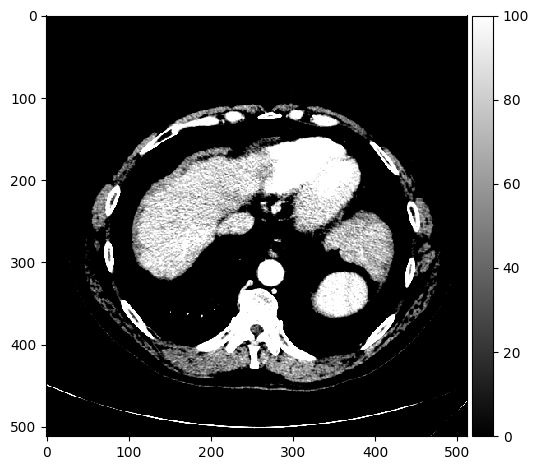

Number of labels: 469
265.0
679.0
6269.0
313.0
243.0
290.0
329.0
251.0
297.0
1354.0
264.0
368.0
261.0
783.0
2096.0
4345.0
428.0
456.0
292.0
467.0
206.99287410926365
12.658963440876713


In [5]:
ct = dicom.read_file('./may2022/Aorta/1-442.dcm') #single dicom slice w/ annotations
img = ct.pixel_array #extract pixel data, already hounsfield units -> its the format for dicom images
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

T = 90
bin_aorta = img > T

bin_aorta = segmentation.clear_border(bin_aorta) #remove all border blobs
label_img = measure.label(bin_aorta, connectivity=2) # 2 for 8 connectivity
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs
region_props = measure.regionprops(label_img)

C = 0.95
count = 0
aorta = []

label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    if area > 200:
        print(area)
        perim = region.perimeter
        if perim != 0:
            circularity = (4 * 3.14 * area / (perim**2))
            if circularity > C:
                print(f"circ: {circularity}")
                aorta.append(area)
    else:
        pass

roi_aorta = io.imread('./may2022/Aorta/AortaROI.png')
aorta_mask = roi_aorta > 0 #white values
aorta_values = img[aorta_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_aorta = np.mean(aorta_values)
std_aorta = np.std(aorta_values)


print(mu_aorta)
print(std_aorta)




In [6]:
liver_roi = io.imread('./may2022/Aorta/LiverROI.png')
liver_mask = liver_roi > 0 #white values
liver_values = img[liver_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )
mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)


#threshold = where they intercept
root = -((std_high**2) * (std_liver**2) * (2*mu_aorta*mu_liver - (mu_liver**2) - 2 * (std_liver**2)*math.log(std_liver/std_aorta) - (mu_aorta**2) + 2*(std_aorta**2)*math.log(std_liver/std_aorta)))
denom = -(std_liver**2) + (std_aorta**2)
pt1 = (std_aorta**2) * mu_liver - (std_liver**2)*mu_aorta

v_sum = (pt1 + math.sqrt(root)) / denom
v_dif = (pt1 - math.sqrt(root)) / denom 
print(v_sum)
print(v_dif)

#take the smaller one



150.8467740685213
985.9072465105872


Number of labels: 190


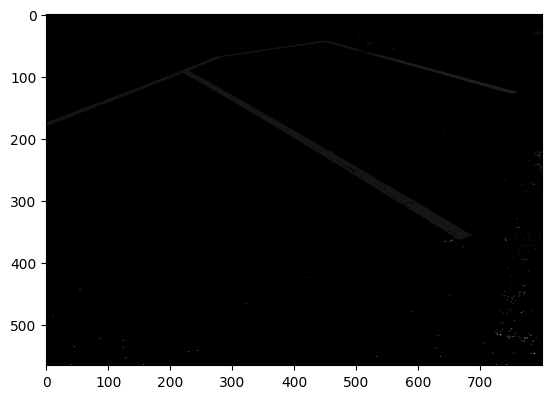

Number of new labels: 23


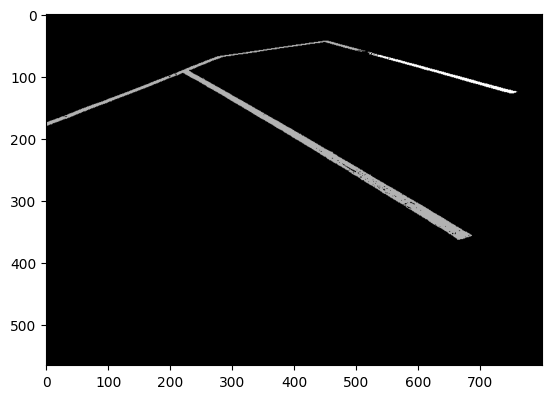

In [7]:
car_dir = './may2022/CarData/car.png'
road_dir = './may2022/CarData/road.png'

road_im  = io.imread(road_dir)
road_hsv = color.rgb2hsv(road_im)
road_v   = road_hsv[:, :, 2]
road_bin = road_v > 0.9

label_img = measure.label(road_bin) # 2 for 8 connectivity
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs
region_props = measure.regionprops(label_img)

plt.imshow(label_img, cmap = 'gray')
plt.show()

minimum_area = 1047


label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    if area < minimum_area: #set all areas with bigger area to black
        for coord in region.coords:
            label_img_filter[coord[0], coord[1]] = 0

n_labels_new = label_img_filter.max()
print(f"Number of new labels: {n_labels_new}")# == number of blobs

plt.imshow(label_img_filter, cmap = 'gray')
plt.show()


In [8]:
car_im = io.imread(car_dir)
car_hsv = color.rgb2hsv(car_im)
car_s = car_hsv[:,:,1]
car_bin = car_s > 0.7

footprint = disk(6)
eroded = binary_erosion(car_bin, footprint)
footprint = disk(4)
dilated = binary_dilation(eroded, footprint)

print(dilated.sum())

31365


In [9]:
import glob
from sklearn import decomposition
from sklearn.decomposition import PCA

def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

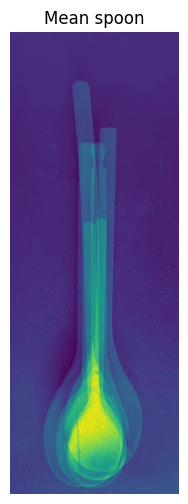

array([188], dtype=uint8)

In [10]:
w = 200
h = 550


in_dir = './may2022/ImagePCA/'
files = glob.glob(f"{in_dir}/*.png")

data_matrix = np.zeros((len(files), h * w))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()
average_spoon = np.mean(data_matrix, axis=0)

average_spoon_img = create_u_byte_image_from_vector(average_spoon, h, w, 1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_spoon_img)
ax.set_title("Mean spoon")
ax.set_axis_off()
plt.show()

average_spoon_img[499][99]


In [11]:
bin_data_matrix = np.zeros((len(files), h * w))

index = 0
for file in files:
    image = io.imread(file)
    im_bin = image > 100
    bin_data_matrix[index, :] = im_bin.flatten()
    index +=1

spoon_pca = PCA()
spoon_pca.fit(bin_data_matrix)

explained_variance = spoon_pca.explained_variance_ratio_
print(explained_variance[0] * 100)

44.398337641924826


In [22]:
print(explained_variance[0] + explained_variance[1]) #take first 2 ciomponents
components = spoon_pca.transform(bin_data_matrix)
pc_1 = components[:, 0]
pc_2 = components[:, 1]

new_mat = np.zeros((1, h*w))
new_spoon = io.imread(f"{in_dir}/spoon1.png")
new_mat[0 , :] = new_spoon.flatten()
cov_mat = np.cov(new_mat)
values, vectors = np.linalg.eig(cov_mat)


pc_proj = vectors.T.dot(bin_data_matrix)

pc_proj

0.6804965564695216


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [30]:
points = np.array([(1, 13), (2, 9), (4,4), (5,2), (5,5), (5,12), (7,7), (10,4), (12,9), (13,9)])

rho = 10
theta = 0
theta_rad = radians(theta)


for (x,y) in points:
    print(x, y)
    #r = xcos(theta) + ysin(theta)
    #y_new = rho/sin(theta_rad) - x*cos(theta_rad)/sin(theta_rad)
    y_new = rho - x*cos(theta_rad)

    print(y_new)

1 13
9.0
2 9
8.0
4 4
6.0
5 2
5.0
5 5
5.0
5 12
5.0
7 7
3.0
10 4
0.0
12 9
-2.0
13 9
-3.0


In [31]:
pass_volc = np.array([(1.2, 1.1),
(2.9, 0.4), (1.7, -2.7), (1.8, -0.3) ,(3.2, 1.3) ,(3.1, -0.9), (0.5, 1.7),
(1.4, -2.1) ,(2.7, -0.8) ,(2.0, 0.5)])


In [ ]:
def LDA(X, y):
    """
    Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    Assumes equal priors among classes

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values.

    Returns
    -------
    W : array-like of shape (n_classes, n_features+1)
        Weights for making the projection. First column is the constants.

    Last modified: 11/11/22, mcbo@dtu.dk
    """
    
    # Determine size of input data
    n, m = X.shape
    # Discover and count unique class labels
    class_label = np.unique(y)
    k = len(class_label)

    # Initialize
    n_group     = np.zeros((k,1))     # Group counts
    group_mean  = np.zeros((k,m))     # Group sample means
    pooled_cov  = np.zeros((m,m))     # Pooled covariance
    W          = np.zeros((k,m+1))    # Model coefficients

    for i in range(k):
        # Establish location and size of each class
        group      = np.squeeze(y == class_label[i])
        n_group[i]  = np.sum(group.astype(np.double))
        
        # Calculate group mean vectors
        group_mean[i,:] = np.mean(X[group,:], axis = 0)
        
        # Accumulate pooled covariance information
        pooled_cov = pooled_cov + ((n_group[i] - 1) / (n - k) ) * np.cov(X[group,:], rowvar = False)
    
    # Assign prior probabilities
    prior_prob = n_group / n

    # Loop over classes to calculate linear discriminant coefficients
    for i in range(k):
        # Intermediate calculation for efficiency
        temp = group_mean[i,:][np.newaxis] @ np.linalg.inv(pooled_cov)
        
        # Constant
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        
        # Linear
        W[i,1:] = temp

    return W


In [56]:
#soccer player PCa analysis
soccer_dir = './may2022/PCAData/soccer_data.txt'
soccer_data = np.loadtxt(soccer_dir,  comments="%")
features = np.array(['short passing', 'long passing', 'acceleration', 'sprint speed', 'agility', 'stamina'])

x = soccer_data
n_feat = x.shape[1]
n_obs = x.shape[0]

mean = np.mean(x, axis = 0)  #computes mean of each feature
data_matrix = x - mean
std = np.std(data_matrix, axis = 0)
data_matrix = data_matrix / std #normalized

cov_mat = np.cov(data_matrix.T)

soccer_pca = PCA()
soccer_pca.fit(x)
explained_variance_soccer = soccer_pca.explained_variance_ratio_

components = soccer_pca.transform(data_matrix)
pc_1 = components[:, 0]
pc_2 = components[:, 1]

max_index = np.argmax(pc_1)
min_index = np.argmin(pc_1)

values, vectors = np.linalg.eig(cov_mat)
print(values)
v_norm = values / values.sum() * 100
max_abs_val = np.max(np.abs(v_norm))
print(max_abs_val)

pc_proj = vectors.T.dot(data_matrix.T)
print(pc_proj)
max_abs_proj = np.max(np.abs(pc_proj))
print(max_abs_proj)


[3.71938584 1.21006534 0.54898592 0.26848584 0.1784549  0.07664714]
61.96884979607209
[[-1.04911288 -1.04911288 -1.04911288 ...  0.37560216  0.37560216
   0.37560216]
 [ 0.67186256  0.67186256  0.67186256 ... -0.1318794  -0.1318794
  -0.1318794 ]
 [ 0.90959677  0.90959677  0.90959677 ...  1.16002668  1.16002668
   1.16002668]
 [ 0.33405974  0.33405974  0.33405974 ... -0.69824437 -0.69824437
  -0.69824437]
 [ 0.37489124  0.37489124  0.37489124 ...  0.1796329   0.1796329
   0.1796329 ]
 [ 0.2316575   0.2316575   0.2316575  ... -0.4386348  -0.4386348
  -0.4386348 ]]
8.524981406455304


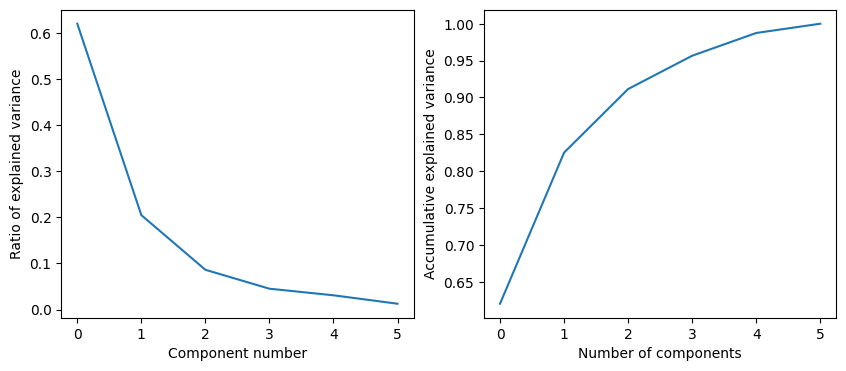

In [57]:

for var in explained_variance:
    var *= 100

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(explained_variance_soccer)
ax[0].set_ylabel("Ratio of explained variance")
ax[0].set_xlabel("Component number")
ax[1].plot(explained_variance_soccer.cumsum())
ax[1].set_ylabel("Accumulative explained variance")
ax[1].set_xlabel("Number of components")
plt.show()


In [90]:
from scipy.io import loadmat #load matrices .mat files
from skimage.transform import SimilarityTransform
from skimage.transform import EuclideanTransform
from skimage.transform import warp, resize
from skimage.transform import swirl
from skimage.transform import matrix_transform

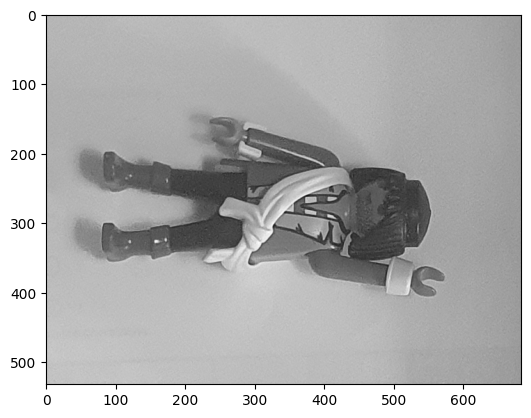

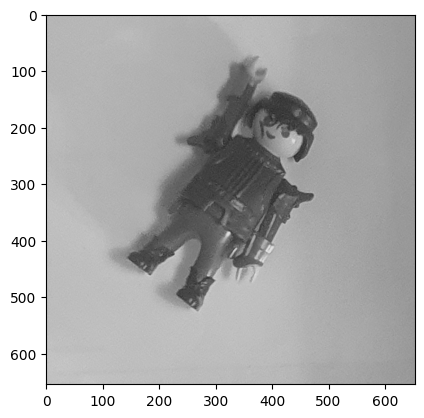

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 28 18:56:04 2022', '__version__': '1.0', '__globals__': [], 'movingPoints': array([[402.39568345, 136.76199041],
       [480.14748201, 194.0941247 ],
       [144.00839329, 434.41786571],
       [267.3117506 , 397.50539568],
       [266.5263789 , 523.95023981]])}


In [91]:
#landmark based reg
play1 = io.imread( './may2022/Landmarks/play1.png')
play5 = io.imread( './may2022/Landmarks/play5.png')

plt.imshow(play1)
plt.show()
plt.imshow(play5)
plt.show()
fixed_data = loadmat('./may2022/Landmarks/playfixedPoints.mat')
moving_data = loadmat('./may2022/Landmarks/playmovingPoints.mat')

print(moving_data)
fixed_landmarks = fixed_data['fixedPoints']
moving_landmarks = moving_data['movingPoints']

In [92]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

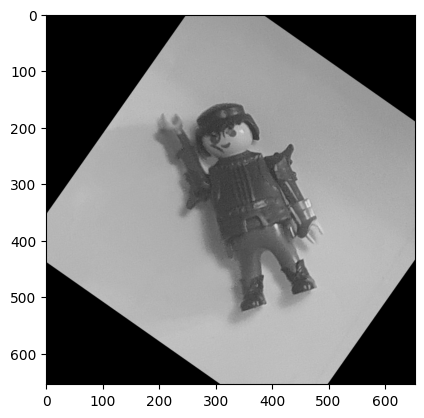

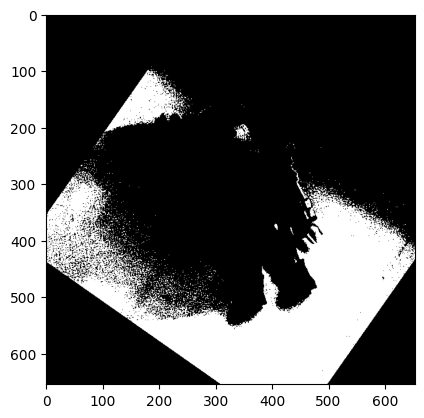

(1028, 1029)
(655, 653, 3)


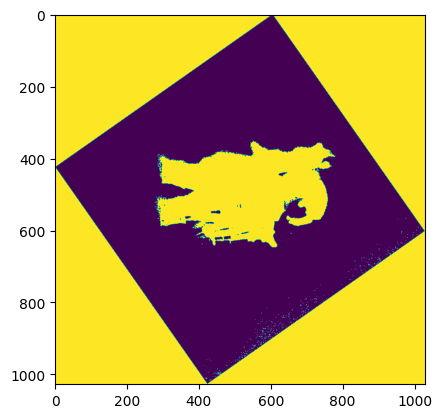

(655, 653, 3)
DICE score 1.042586749568563


In [103]:
tform = SimilarityTransform()
tform.estimate(fixed_landmarks, moving_landmarks)
src_transform = matrix_transform(fixed_landmarks, tform.params) 

warped_im = warp(play5, tform.inverse)
warped_im = img_as_ubyte(warped_im)

plt.imshow(warped_im)
plt.show()

warped_bin = warped_im > 180
warped_bin = img_as_ubyte(warped_bin)
plt.imshow(warped_bin)
plt.show()

ref = io.imread('./may2022/Landmarks/reference.png')
ref - img_as_ubyte(ref)
print(ref.shape)
print(warped_bin.shape)

plt.imshow(ref)
plt.show()

ref_resized = resize(ref, (655, 653, 3))
print(ref_resized.shape)
dice_score = 1 - distance.dice(warped_bin.ravel(), ref_resized.ravel())
print(f"DICE score {dice_score}")

In [108]:
''' 
fixed_landmarks = fixed_data['fixedPoints']
moving_landmarks = moving_data['movingPoints']
'''

#euclidian distance
p1 = fixed_landmarks[0]
p2 = moving_landmarks[0]
dist = math.sqrt(((p1[0] - p2[0])**2) + ((p1[1] - p2[1])**2))
dist

165.7348824957671

In [112]:
#grain classification
'''
Badqualitygrain:N(25,102) 
medium_grain =  N(52, 2 ) 
High quality grain: N(150, 302)'''

mu_med = 52
std_med = 2

mu_high = 150
std_high = 30

root = -((std_high**2) * (std_med**2) * (2*mu_high*mu_med - (mu_med**2) - 2 * (std_med**2)*math.log(std_med/std_high) - (mu_high**2) + 2*(std_high**2)*math.log(std_med/std_high)))
denom = -(std_med**2) + (std_high**2)
pt1 = (std_high**2) * mu_med - (std_med**2)*mu_high

v_sum = (pt1 + math.sqrt(root)) / denom
v_dif = (pt1 - math.sqrt(root)) / denom 

print(v_sum)
print(v_dif)

(mu_med + 25) / 2

59.61405413180763
43.51094586819237


38.5